In [6]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


In [7]:
class Creature(Agent):
    def __init__(self, unique_id, model, trait=None, mutation_rate=0.01):
       super().__init__(unique_id, model)
       self.trait = trait if trait is not None else model.random.random() # Assign a single trait to each agent
       self.environment_factor = model.environment_factor
       self.mutation_rate = mutation_rate
        
    def move(self):
        # Get the current environmental factor
        current_environment_factor = self.model.environment_grid[self.pos[0]][self.pos[1]]

        # Get the environmental factors of the neighboring cells
        neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        neighbor_environment_factors = [self.model.environment_grid[pos[0]][pos[1]] for pos in neighborhood]

        # If the current environmental factor is higher than the lowest neighboring environmental factor, move to the neighboring cell with the lowest environmental factor
        if current_environment_factor > min(neighbor_environment_factors):
            min_environment_factor_pos = neighborhood[neighbor_environment_factors.index(min(neighbor_environment_factors))]
            self.model.grid.move_agent(self, min_environment_factor_pos)
            
    def step(self):
        self.move()
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        neighbor_traits = [neighbor.trait for neighbor in neighbors]
        
        # Calculate the average trait of the neighbors
        avg_neighbor_trait = np.mean(neighbor_traits) if neighbors else self.trait
        
        # Calculate the difference between the agent's trait and the average trait of the neighbors
        trait_difference = avg_neighbor_trait - self.trait
        
        # Update the agent's trait based on the trait difference, environmental factor, and mutation rate
        self.trait += self.model.selection_pressure * 0.1 * trait_difference * self.environment_factor
        
        # Introduce mutation: Randomly change the agent's trait with a certain probability (mutation rate)
        if self.model.random.random() < self.mutation_rate:
           self.trait += self.model.random.normalvariate(0, 0.1) # You can adjust the mutation magnitude

In [8]:
class EvolutionModel(Model):
    def __init__(self, N, width, height, environment_factor, mutation_rate, selection_pressure, initial_traits=None,terrain=None):
       self.num_agents = N
       self.grid = MultiGrid(width, height, True)
       self.schedule = RandomActivation(self)
       self.environment_factor = environment_factor
       self.mutation_rate = mutation_rate
       self.selection_pressure = selection_pressure
       self.environment_grid = terrain if terrain is not None else np.random.normal(0.5, 0.1, (width, height)) # Create a grid of environmental factors

       # If initial traits are provided, each agent is assigned one of the predefined traits
       if initial_traits:
           for i in range(self.num_agents):
               agent_trait = initial_traits[i % len(initial_traits)]
               agent = Creature(i, self, trait=agent_trait, mutation_rate=mutation_rate)
               x = np.random.choice(self.grid.width)
               y = np.random.choice(self.grid.height)
               self.grid.place_agent(agent, (x, y))
               self.schedule.add(agent)
       else:
           # If no initial traits are provided, create agents with random traits
           for i in range(self.num_agents):
               agent = Creature(i, self, mutation_rate=mutation_rate)
               x = np.random.choice(self.grid.width)
               y = np.random.choice(self.grid.height)
               self.grid.place_agent(agent, (x, y))
               self.schedule.add(agent)

       self.datacollector = DataCollector(agent_reporters={"x": lambda a: a.pos[0], 
                                                        "y": lambda a: a.pos[1], 
                                                        "Trait": lambda a: a.trait, # Report only one trait
                                                        "Environment Factor": "environment_factor"})

    def step(self):
        # Update the environment grid
        self.environment_grid += np.random.normal(0, 0.01, self.environment_grid.shape)  # Add random noise to simulate environmental changes
        self.environment_grid = np.clip(self.environment_grid, 0, 1)  # Ensure environmental factors stay within the range [0, 1]
        self.datacollector.collect(self)
        self.schedule.step()

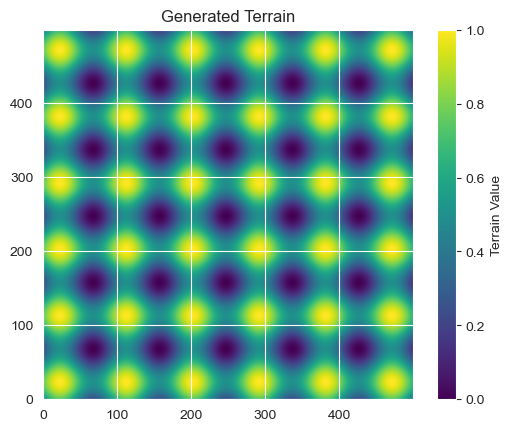

In [20]:
def generate_terrain(width, height, complexity=5, scale=100):
    terrain = np.zeros((width, height))

    for i in range(width):
        for j in range(height):
            terrain[i][j] = np.sin(i / scale * complexity) + np.sin(j / scale * complexity)

    # Normalize the values to the range [0, 1]
    terrain = (terrain - np.min(terrain)) / (np.max(terrain) - np.min(terrain))

    return terrain

# Example usage:
width = 500
height = 500
terrain = generate_terrain(width, height, complexity=7, scale=100)

# Visualize the terrain
plt.imshow(terrain, cmap='viridis', origin='lower')
plt.colorbar(label='Terrain Value')
plt.title('Generated Terrain')
plt.show()

In [ ]:
# Run the model for a certain number of steps
user_defined_environment_factor = 1
user_defined_mutation_rate = 0.01
user_defined_initial_traits = [0.2, 0.8, 0.5]
user_defined_selection_pressure = 0.1
N_steps = 100000 # Increase this to get a longer time series
N_agents = 500
width = 500
height = 500
terrain = generate_terrain(width, height, complexity=5, scale=100)

model = EvolutionModel(N_agents, width, height, user_defined_environment_factor, user_defined_mutation_rate, user_defined_selection_pressure, initial_traits=user_defined_initial_traits,terrain=terrain)
for i in range(N_steps):
    model.step()
# print(f"Number of steps in the model: {model.schedule.steps}")
# Extract and visualize data collected during the simulation
agent_data = model.datacollector.get_agent_vars_dataframe()
# print(f"Number of rows in agent_data: {len(agent_data)}")
# print(agent_data)
# Get data for the last step
last_step_data = agent_data.xs(N_steps-1, level="Step")

# Unstack the data for plotting
unstacked_data = last_step_data.unstack()

In [ ]:
# Plot the trait of the agents
plt.figure(figsize=(20, 5))
unstacked_data["Trait"].plot()
plt.xlabel('Steps')
plt.ylabel('Trait')
plt.title(f'Evolution Simulation Trait over Time')

In [ ]:
# Visualize the spatial distribution of the trait and environmental factors in the last step
fig, ax = plt.subplots()
sc = ax.scatter(last_step_data["x"], last_step_data["y"], c=last_step_data["Trait"].values * last_step_data["Environment Factor"].values, cmap='viridis')
plt.colorbar(sc, label='Trait * Environment Factor')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Spatial Distribution of Trait * Environment Factor')
plt.show()

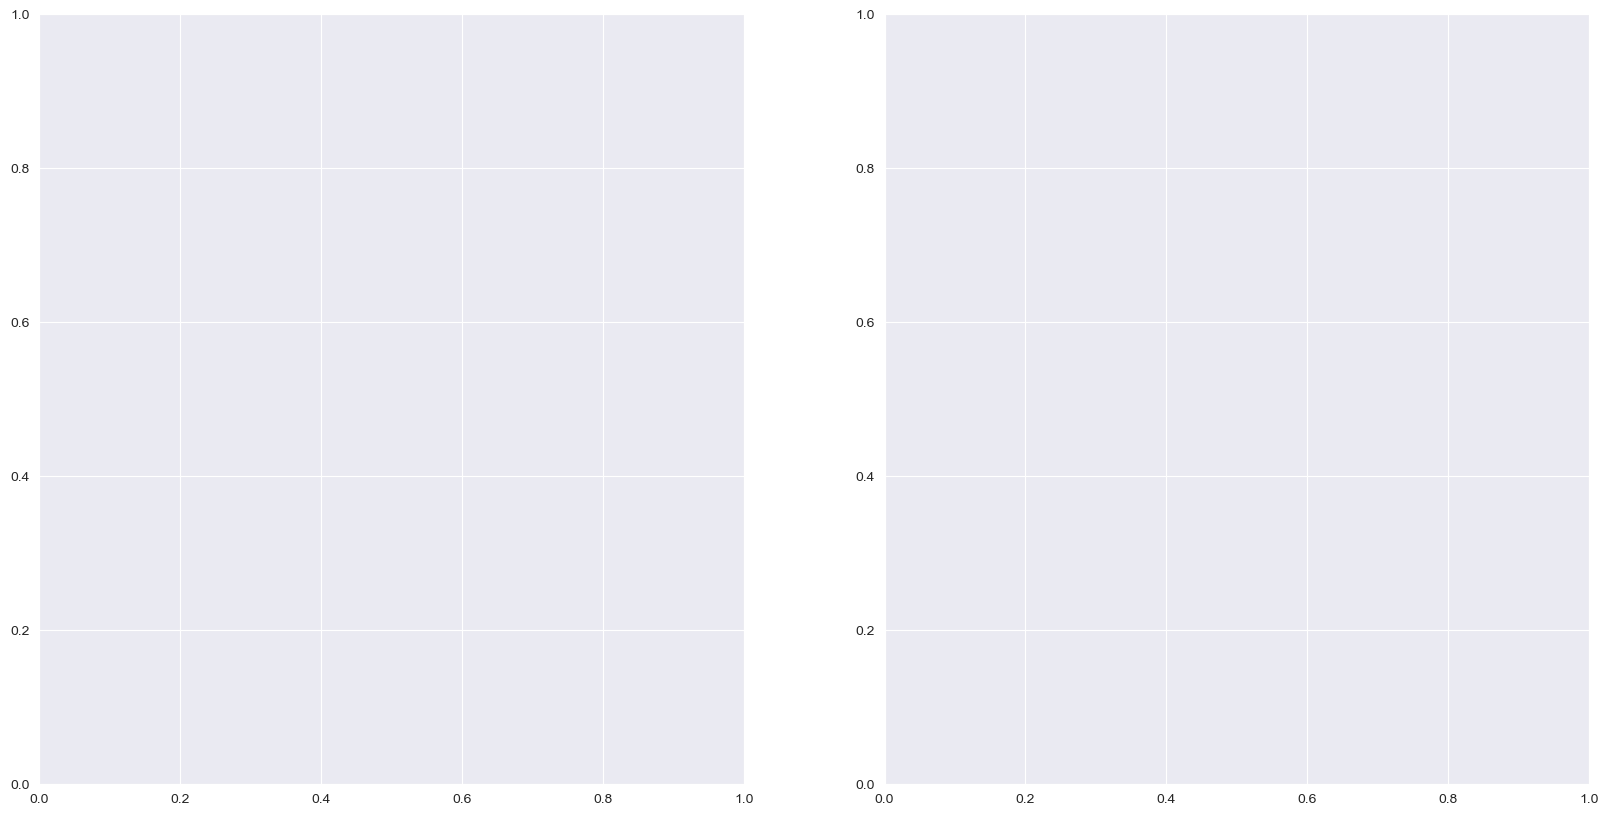

In [18]:
# Function to update the plot
fig, ax = plt.subplots(1, 2, figsize=(20, 10)) # Create a figure with two subplots
agent_data_reset = agent_data.reset_index()

def update(i):
     print(i)
     fig.clear()
     # Filter the data for each step
     step_data = agent_data_reset[agent_data_reset["Step"] == i]
    
     ax[0] = fig.add_subplot(121)
     sc_local = ax[0].scatter(step_data["x"], step_data["y"], c=step_data["Trait"].values, cmap='Spectral') # Make the size of each marker unique
     plt.xlabel('X')
     plt.ylabel('Y')
     plt.title(f'Spatial Distribution Step {i}')
     sc_local.set_offsets(np.column_stack((step_data["y"], step_data["x"])))
     cbar = fig.colorbar(sc_local, ax=ax[0], label = 'Trait * Environment Factor')
    
     # Add a heatmap to the second subplot
     heatmap_data = np.histogram2d(step_data["x"], step_data["y"], weights=step_data["Trait"].values, bins=50)[0]
     ax[1] = fig.add_subplot(122)
     ax[1].imshow(heatmap_data, extent=(0, width, 0, height), alpha=0.5, cmap='viridis')
     ax[1].set_title('Heatmap of Trait Distribution')

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


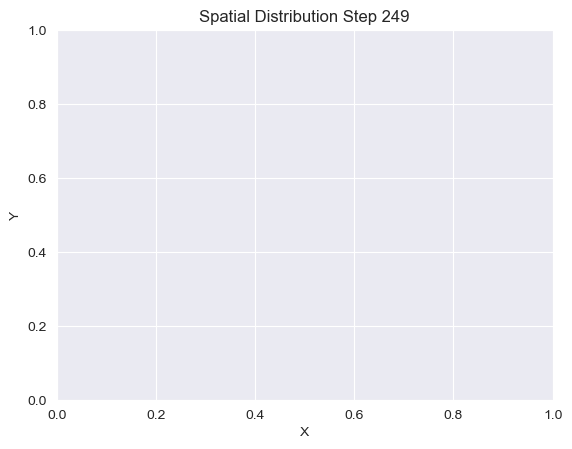

In [19]:
# Create an animation
ani = FuncAnimation(fig, update, frames = N_steps, repeat=True)

# Save the animation as a video file
ani.save('trait.mp4', writer='ffmpeg')

In [239]:
print(agent_data)
print(plt.colormaps())

                x    y     Trait  Environment Factor
Step AgentID                                        
0    0        323  140  0.200000                   1
     1        437  466  0.800000                   1
     2         38   54  0.500000                   1
     3        354   34  0.200000                   1
     4        299  100  0.800000                   1
...           ...  ...       ...                 ...
249  495      196  121  0.033635                   1
     496      317  346  0.652277                   1
     497      129  397  0.500000                   1
     498      159  154  0.332395                   1
     499      451  436  0.824919                   1

[125000 rows x 4 columns]
['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlG

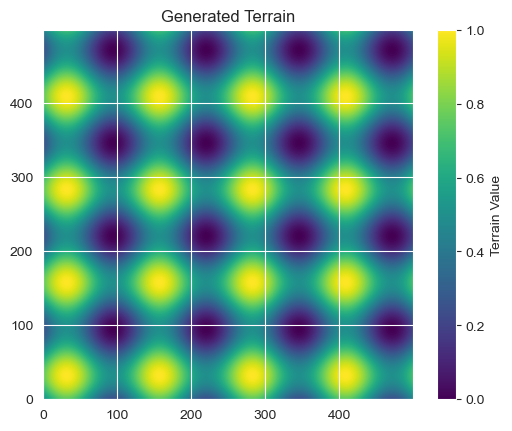

In [2]:
def generate_terrain(width, height, complexity=5, scale=100):
    terrain = np.zeros((width, height))

    for i in range(width):
        for j in range(height):
            terrain[i][j] = np.sin(i / scale * complexity) + np.sin(j / scale * complexity)

    # Normalize the values to the range [0, 1]
    terrain = (terrain - np.min(terrain)) / (np.max(terrain) - np.min(terrain))

    return terrain

# Example usage:
width = 500
height = 500
terrain = generate_terrain(width, height, complexity=5, scale=100)

# Visualize the terrain
plt.imshow(terrain, cmap='viridis', origin='lower')
plt.colorbar(label='Terrain Value')
plt.title('Generated Terrain')
plt.show()